<a href="https://colab.research.google.com/github/sathyanarayanajammala/GenAI/blob/main/Copy_of_M3_AST_2_Transformer_Decoder_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative AI and Prompt Engineering
## A Program by IISc and TalentSprint



Assignment: **Decoder only Transformer (GPT)**

## Learning Objectives

At the end of the experiment you will be able to  :

1. understand and implement Causal Self Attention
2. create decoder only architecture i.e. GPT
3. train and generate text from custom-built GPT

In [1]:
%%capture
!pip -q install transformers datasets

## Setup Steps

In [2]:
#@title Please enter your registration id to start: { run: "auto", display-mode: "form" }
Id = "2416497" #@param {type:"string"}

In [3]:
#@title Please enter your password (your registered phone number) to continue: { run: "auto", display-mode: "form" }
password = "6301058763" #@param {type:"string"}

In [4]:
#@title Run this cell to complete the setup for this Notebook
from IPython import get_ipython

ipython = get_ipython()

notebook= "M3_AST_2_Transformer_Decoder_B" #name of the notebook

def setup():
#  ipython.magic("sx pip3 install torch")

    from IPython.display import HTML, display
    display(HTML('<script src="https://dashboard.talentsprint.com/aiml/record_ip.html?traineeId={0}&recordId={1}"></script>'.format(getId(),submission_id)))
    print("Setup completed successfully")
    return

def submit_notebook():
    ipython.magic("notebook -e "+ notebook + ".ipynb")

    import requests, json, base64, datetime

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:
        print(r["err"])
        return None
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None

    elif getAnswer() and getComplexity() and getAdditional() and getConcepts() and getComments() and getMentorSupport():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional,
              "concepts" : Concepts, "record_id" : submission_id,
              "answer" : Answer, "id" : Id, "file_hash" : file_hash,
              "notebook" : notebook,
              "feedback_experiments_input" : Comments,
              "feedback_mentor_support": Mentor_support}
      r = requests.post(url, data = data)
      r = json.loads(r.text)
      if "err" in r:
        print(r["err"])
        return None
      else:
        print("Your submission is successful.")
        print("Ref Id:", submission_id)
        print("Date of submission: ", r["date"])
        print("Time of submission: ", r["time"])
        print("View your submissions: https://genai-iisc.talentsprint.com/notebook_submissions")
        #print("For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.")
        return submission_id
    else: submission_id


def getAdditional():
  try:
    if not Additional:
      raise NameError
    else:
      return Additional
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    if not Complexity:
      raise NameError
    else:
      return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None

def getConcepts():
  try:
    if not Concepts:
      raise NameError
    else:
      return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None


# def getWalkthrough():
#   try:
#     if not Walkthrough:
#       raise NameError
#     else:
#       return Walkthrough
#   except NameError:
#     print ("Please answer Walkthrough Question")
#     return None

def getComments():
  try:
    if not Comments:
      raise NameError
    else:
      return Comments
  except NameError:
    print ("Please answer Comments Question")
    return None


def getMentorSupport():
  try:
    if not Mentor_support:
      raise NameError
    else:
      return Mentor_support
  except NameError:
    print ("Please answer Mentor support Question")
    return None

def getAnswer():
  try:
    if not Answer:
      raise NameError
    else:
      return Answer
  except NameError:
    print ("Please answer Question")
    return None


def getId():
  try:
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup()
else:
  print ("Please complete Id and Password cells before running setup")

Setup completed successfully


### Importing packages

In [5]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import dataset
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from torch.utils.data import DataLoader

from datetime import datetime

# **1.Decoder Only Transformer (GPT) Architecture**

The diagram below is showing the **Decoder only architecture** which is equivalent to the encoder architecture. But the Transformer block contains masked multi-head attention instead of plain multi-head attention.

<br><br>
<center>
<img src= "https://cdn.extras.talentsprint.com/aiml/Experiment_related_data/Images/decoder_tfr.png" width=950px/>
</center>

The figure below shows the expanded **Transformer block used in Decoder** architecture and we can see the masked multi-head attention. Multi-head attention with masking is known as causal self-attention. Causal means the model can look only at the past.

<br><br>
<center>
<img src= "https://cdn.extras.talentsprint.com/aiml/Experiment_related_data/Images/decoder_tfr_block.png" width=200px/>
</center>

## **Implementation of Causal Multihead Attention**

**Attention weights for Causal Self-Attention**

* Force attention weights to only pay attention to the past input tokens
* Attention weights are a TxT square matrix
* $ \alpha(i,j) $ is "How much i pays attention to j"
* Causal means  : $ \alpha(i,j) > 0 $ only when $i >= j$
* We can multiply by a mask to enforce this as shown below.
<br><br>
 $ \qquad Initial \ Attention\ weights  \qquad \qquad  Zero \ Upper \ Triangular Matrics \qquad \qquad Causal \ Self-Attention $

<center>

<img src= "https://cdn.extras.talentsprint.com/aiml/Experiment_related_data/Images/causal_attention_weigts.png" width=950px/>

## **Causal SelfAttention**

>**Step-by-Step Explanation**

1. **Initialization (`__init__` method)**

```python
self.d_k = d_k
self.n_heads = n_heads

self.key = nn.Linear(d_model, d_k * n_heads)
self.query = nn.Linear(d_model, d_k * n_heads)
self.value = nn.Linear(d_model, d_k * n_heads)

self.fc = nn.Linear(d_k * n_heads, d_model)
```

- **`d_k`**: The dimensionality of each key (and query and value) vector per head.
- **`d_model`**: The input feature size, usually the embedding dimension.
- **`n_heads`**: The number of attention heads.
- **`key`, `query`, `value`**: Linear layers to transform the input tensor into keys, queries, and values for each head.
- **`fc`**: Final linear layer to transform the concatenated output of all attention heads back to the original `d_model` dimension.

2. **Creating the Causal Mask**

```python
cm = torch.tril(torch.ones(int(max_len), int(max_len)))
self.register_buffer("causal_mask", cm.view(1, 1, int(max_len), int(max_len)))
```

- **`cm`**: A lower triangular matrix where each element above the main diagonal is set to zero. This prevents the model from "seeing" future positions during training (causal self-attention).

3. **Forward Pass (`forward` method)**

```python
q = self.query(q)  # N x T x (h*d_k)
k = self.key(k)    # N x T x (h*d_k)
v = self.value(v)  # N x T x (h*d_k)
```

- Here, the input tensors `q`, `k`, and `v` are transformed using the linear layers to obtain the queries, keys, and values. The resulting shape is `(N, T, h*d_k)`, where:
  - `N` is the batch size.
  - `T` is the sequence length.
  - `h*d_k` is the total number of dimensions after linear transformation (number of heads × dimension per head).

4. **Reshape and Transpose for Multi-Head Attention**

```python
q = q.view(N, T, self.n_heads, self.d_k).transpose(1, 2)  # (N, h, T, d_k)
k = k.view(N, T, self.n_heads, self.d_k).transpose(1, 2)  # (N, h, T, d_k)
v = v.view(N, T, self.n_heads, self.d_k).transpose(1, 2)  # (N, h, T, d_k)
```

- The `view` and `transpose` operations reshape the tensors to separate the heads. The resulting shape is `(N, h, T, d_k)`, making it easier to perform parallel attention computations for each head.

5. **Compute Scaled Dot-Product Attention Scores**

```python
attn_scores = q @ k.transpose(-2, -1) / math.sqrt(self.d_k)  # (N, h, T, T)
```

- This step computes the attention scores using the formula:

$$
Attention Scores = \frac {{QK^T}} {\sqrt{d_k}}
$$


- `q @ k.transpose(-2, -1)` performs matrix multiplication between `q` and `k`. The shape of the result is `(N, h, T, T)`.

- **Why the division by \(\sqrt{d_k}\)?** This scaling factor helps in stabilizing gradients during training by preventing extremely large values in the softmax.

6. **Apply Masks**

```python
if pad_mask is not None:
    attn_scores = attn_scores.masked_fill(pad_mask[:, None, None, :] == 0, float('-inf'))

attn_scores = attn_scores.masked_fill(self.causal_mask[:, :, :T, :T] == 0, float('-inf'))
```

- **Padding Mask (`pad_mask`)**: This ensures that the model does not attend to padded positions in the sequence.

- **Causal Mask**: Ensures that each position only attends to previous positions (or itself).

7. **Compute Attention Weights**

```python
attn_weights = F.softmax(attn_scores, dim=-1)  # (N, h, T, T)
```

- Applies the softmax function to convert scores into probabilities, making sure they sum up to 1 along the last dimension (`T`).

8. **Compute Weighted Sum of Values**

```python
A = attn_weights @ v  # (N, h, T, d_k)
```

- Computes the weighted sum of values using the attention weights. The shape of `A` is `(N, h, T, d_k)`.

9. **Reshape and Final Linear Layer**

```python
A = A.transpose(1, 2).contiguous().view(N, T, self.d_k * self.n_heads)  # (N, T, h*d_k)
return self.fc(A)  # (N, T, d_model)
```

- Reshapes `A` back to `(N, T, h*d_k)` and applies the final linear transformation to get the output shape `(N, T, d_model)`.

**Example Calculation**

Let's take a small example to clarify the forward pass:

- **Input Details:**
  - `d_model = 6`, `d_k = 2`, `n_heads = 3`, `max_len = 4`.
  - `q`, `k`, and `v` are tensors of shape `(1, 4, 6)` representing a batch size of 1, sequence length of 4, and model dimension of 6.

1. **Linear Transformations:**
    - `q = self.query(q)` transforms `(1, 4, 6)` into `(1, 4, 6)` since `d_k * n_heads = 6`.
    - Similarly for `k` and `v`.

2. **Reshape and Transpose:**
    - `q.view(1, 4, 3, 2).transpose(1, 2)` results in `(1, 3, 4, 2)`.
    - The same goes for `k` and `v`.

3. **Attention Scores:**
    - `attn_scores = q @ k.transpose(-2, -1) / sqrt(2)` gives a tensor of shape `(1, 3, 4, 4)`.

4. **Apply Masks:**
    - If there's a mask, elements are set to `-inf` where the mask is `0`.

5. **Attention Weights and Weighted Sum:**
    - `attn_weights = softmax(attn_scores, dim=-1)` results in probabilities along the last dimension.
    - `A = attn_weights @ v` results in `(1, 3, 4, 2)`.

6. **Final Reshape and Linear Layer:**
    - `A` is reshaped to `(1, 4, 6)`.
    - `self.fc(A)` gives the final output of shape `(1, 4, 6)`.


In [ ]:
class CausalSelfAttention(nn.Module):
  def __init__(self, d_k,d_model, n_heads, max_len):
    super().__init__()

    # Assume d_v =d_k
    self.d_k=d_k
    self.n_heads = n_heads

    self.key = nn. Linear (d_model, d_k*n_heads)
    self.query = nn. Linear (d_model, d_k*n_heads)
    self.value = nn. Linear (d_model, d_k*n_heads)

    # final linear layer
    self.fc=nn.Linear (d_k*n_heads, d_model)

    # casual mask
    # make it so that diagonal is 0
    # this way we don't have to shift the inputs to make targets

    cm=torch.tril(torch.ones(int(max_len),int(max_len)))
    self.register_buffer("causal_mask",  cm.view(1,1, int(max_len), int(max_len)))


  def forward(self, q, k, v, pad_mask=None):
    q=self.query(q) # N x T x (hd_k)
    k=self.key(k) # N x T x (hd_k)
    v=self.value(v) # N x T x (hd_k)

    N = q.shape[0]
    T = q.shape[1]


    # change the shape to:
    # (N, T, h, d_k) --> N, h, T, d_k)
    # in order for matrix multiply to work properly
    q=q.view (N, T, self.n_heads, self.d_k).transpose(1,2)
    k=k.view (N, T, self.n_heads, self.d_k).transpose(1,2)
    v=v.view (N, T, self.n_heads, self.d_k).transpose(1,2)

    # Copute attention weights
    # (N, h, T, d_k)   x  (N, h, d_k, T )  --> (N, h, T, T)
    attn_scores = q@k.transpose(-2,-1)/math.sqrt(self.d_k) # Scaled dot product;  @ --> torch.matmul

    if pad_mask is not None:
      attn_scores = attn_scores.masked_fill(pad_mask[:,None,None,:] == 0, float('-inf'))

    attn_scores = attn_scores.masked_fill(self.causal_mask[:, :, :T, :T] == 0, float('-inf'))

    attn_weights = F.softmax(attn_scores, dim =-1)

    # Compute attention-weighted values
    # (N, h, T, T) x (N, h, T, d_k) --> (N, h, T, d_k)
    A = attn_weights @ v

    # reshape it back before final linear layer
    A = A.transpose(1,2)  # (N, T, h, d_k)
    A = A.contiguous(). view(N, T, self.d_k*self.n_heads) # (N, T, h*d_k)

    # projection
    return self.fc(A)

## **Implementation of Transformer Block**

<center>
<img src='https://drive.google.com/uc?id=1sOHG0cPuSJd1S0Yd5mTapfEqK3hzDqT6'>
</center>

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, d_k, d_model, n_heads, max_len, dropout_prob = 0.1):
    super().__init__()

    self.ln1 = nn.LayerNorm(d_model)
    self.ln2 = nn.LayerNorm(d_model)
    self.mha = CausalSelfAttention(d_k, d_model, n_heads, max_len)

    self.ann = nn.Sequential(
        nn.Linear(d_model, d_model*4),
        nn.GELU(),
        nn.Linear(d_model*4, d_model),
        nn.Dropout(dropout_prob),
    )

    self.dropout = nn.Dropout(p=dropout_prob)

  def forward (self, x, pad_mask=None):
    x = self.ln1(x + self.mha(x, x, x, pad_mask))
    x = self.ln2(x + self.ann(x))
    x = self.dropout(x)
    return x

## **Positional Encoding**

**Positional Encoding**

Passing embeddings directly into the transformer block results in missing of information about the order of tokens. As attention is permutation invariant i.e. order of token does not matter to attention.
Although transformers are a sequence model, it appears that this important detail has somehow been lost. Positional encoding is for rescue.

Positional encoding add positional information to the existing embeddings.

**A unique set of numbers added at each position of the existing embeddings**, such that this new set of numbers can uniquely identify which postion they are located at.

> Positional Encoding scheme as per the paper - "Attention Is All You Need" (Non-Trainable)
>
> In this scheme the encoding is created by using a set of sins and cosines at different frequencies. The  paper uses the following formula for calculating the positional encoding. [Positional Encoding Vizualization.](https://erdem.pl/2021/05/understanding-positional-encoding-in-transformers)
>
> $$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
> $$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$
>
> Here:
>
> * $pos$: Position of an object in the input sequence
>
> * $d_{model}$: Dimension of the output embedding space
>
> * $PE_{(pos,j)}$: Position function for mapping a position $pos$ in the input sequence to index $(pos,j)$ of the positional matrix
>
> * $10000$: User-defined scalar (set to 10000 by the authors of "Attention Is All You Need.")
>
> * $i$: Used for mapping to column indices $0 \le i < d_{model}/2 $, with a single value of $i$ maps to both sine and cosine functions
>
> In the above expression, you can see that **even positions correspond to a sine** function and **odd positions correspond to cosine** functions.

We are going to implement PositionalEncoding same as per the paper.

Below figure describes how Positional Encodings are added to each Token Embedding.

<img src='https://drive.google.com/uc?id=13GHEaMFSZ2uT1kuQ8AH-hrPA9HIlA1Qw'>

<br>

Below figure describes the Positional Encoding matrix for a simple example with $seq\_length=4$, $d_{model}=4$, $n=100$(instead of 10000).

<img src='https://drive.google.com/uc?id=17nRDuMKNZzI_6yzmwgTU905YQDfnH5iP' width=900px>

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len =2048, dropout_porb=0.1):
    super().__init__()
    self.dropout = nn.Dropout(p = dropout_porb)

    position = torch.arange(max_len).unsqueeze(1)
    i = torch.arange(0, d_model//2)
    pe = torch.zeros(1, max_len, d_model)
    pe[0, :, 0::2] = torch.sin(position / (10000)**(2*i/d_model))
    pe[0, :, 1::2] = torch.cos(position / (10000)**(2*i/d_model))
    self.register_buffer('pe', pe)    # If you have parameters in your model which should be saved and restored in the state_dict
                                      # but not trained by the optimizer, then you should register them as buffers.
                                      # Buffers won’t be returned in model.parameters(), so that the optimizer won’t have a change to update them.

  def forward(self, x):
    # x.shape : N x T x D
    x = x + self.pe[:, :x.size(1), :]
    return self.dropout(x)

## **Decoder Transformer**


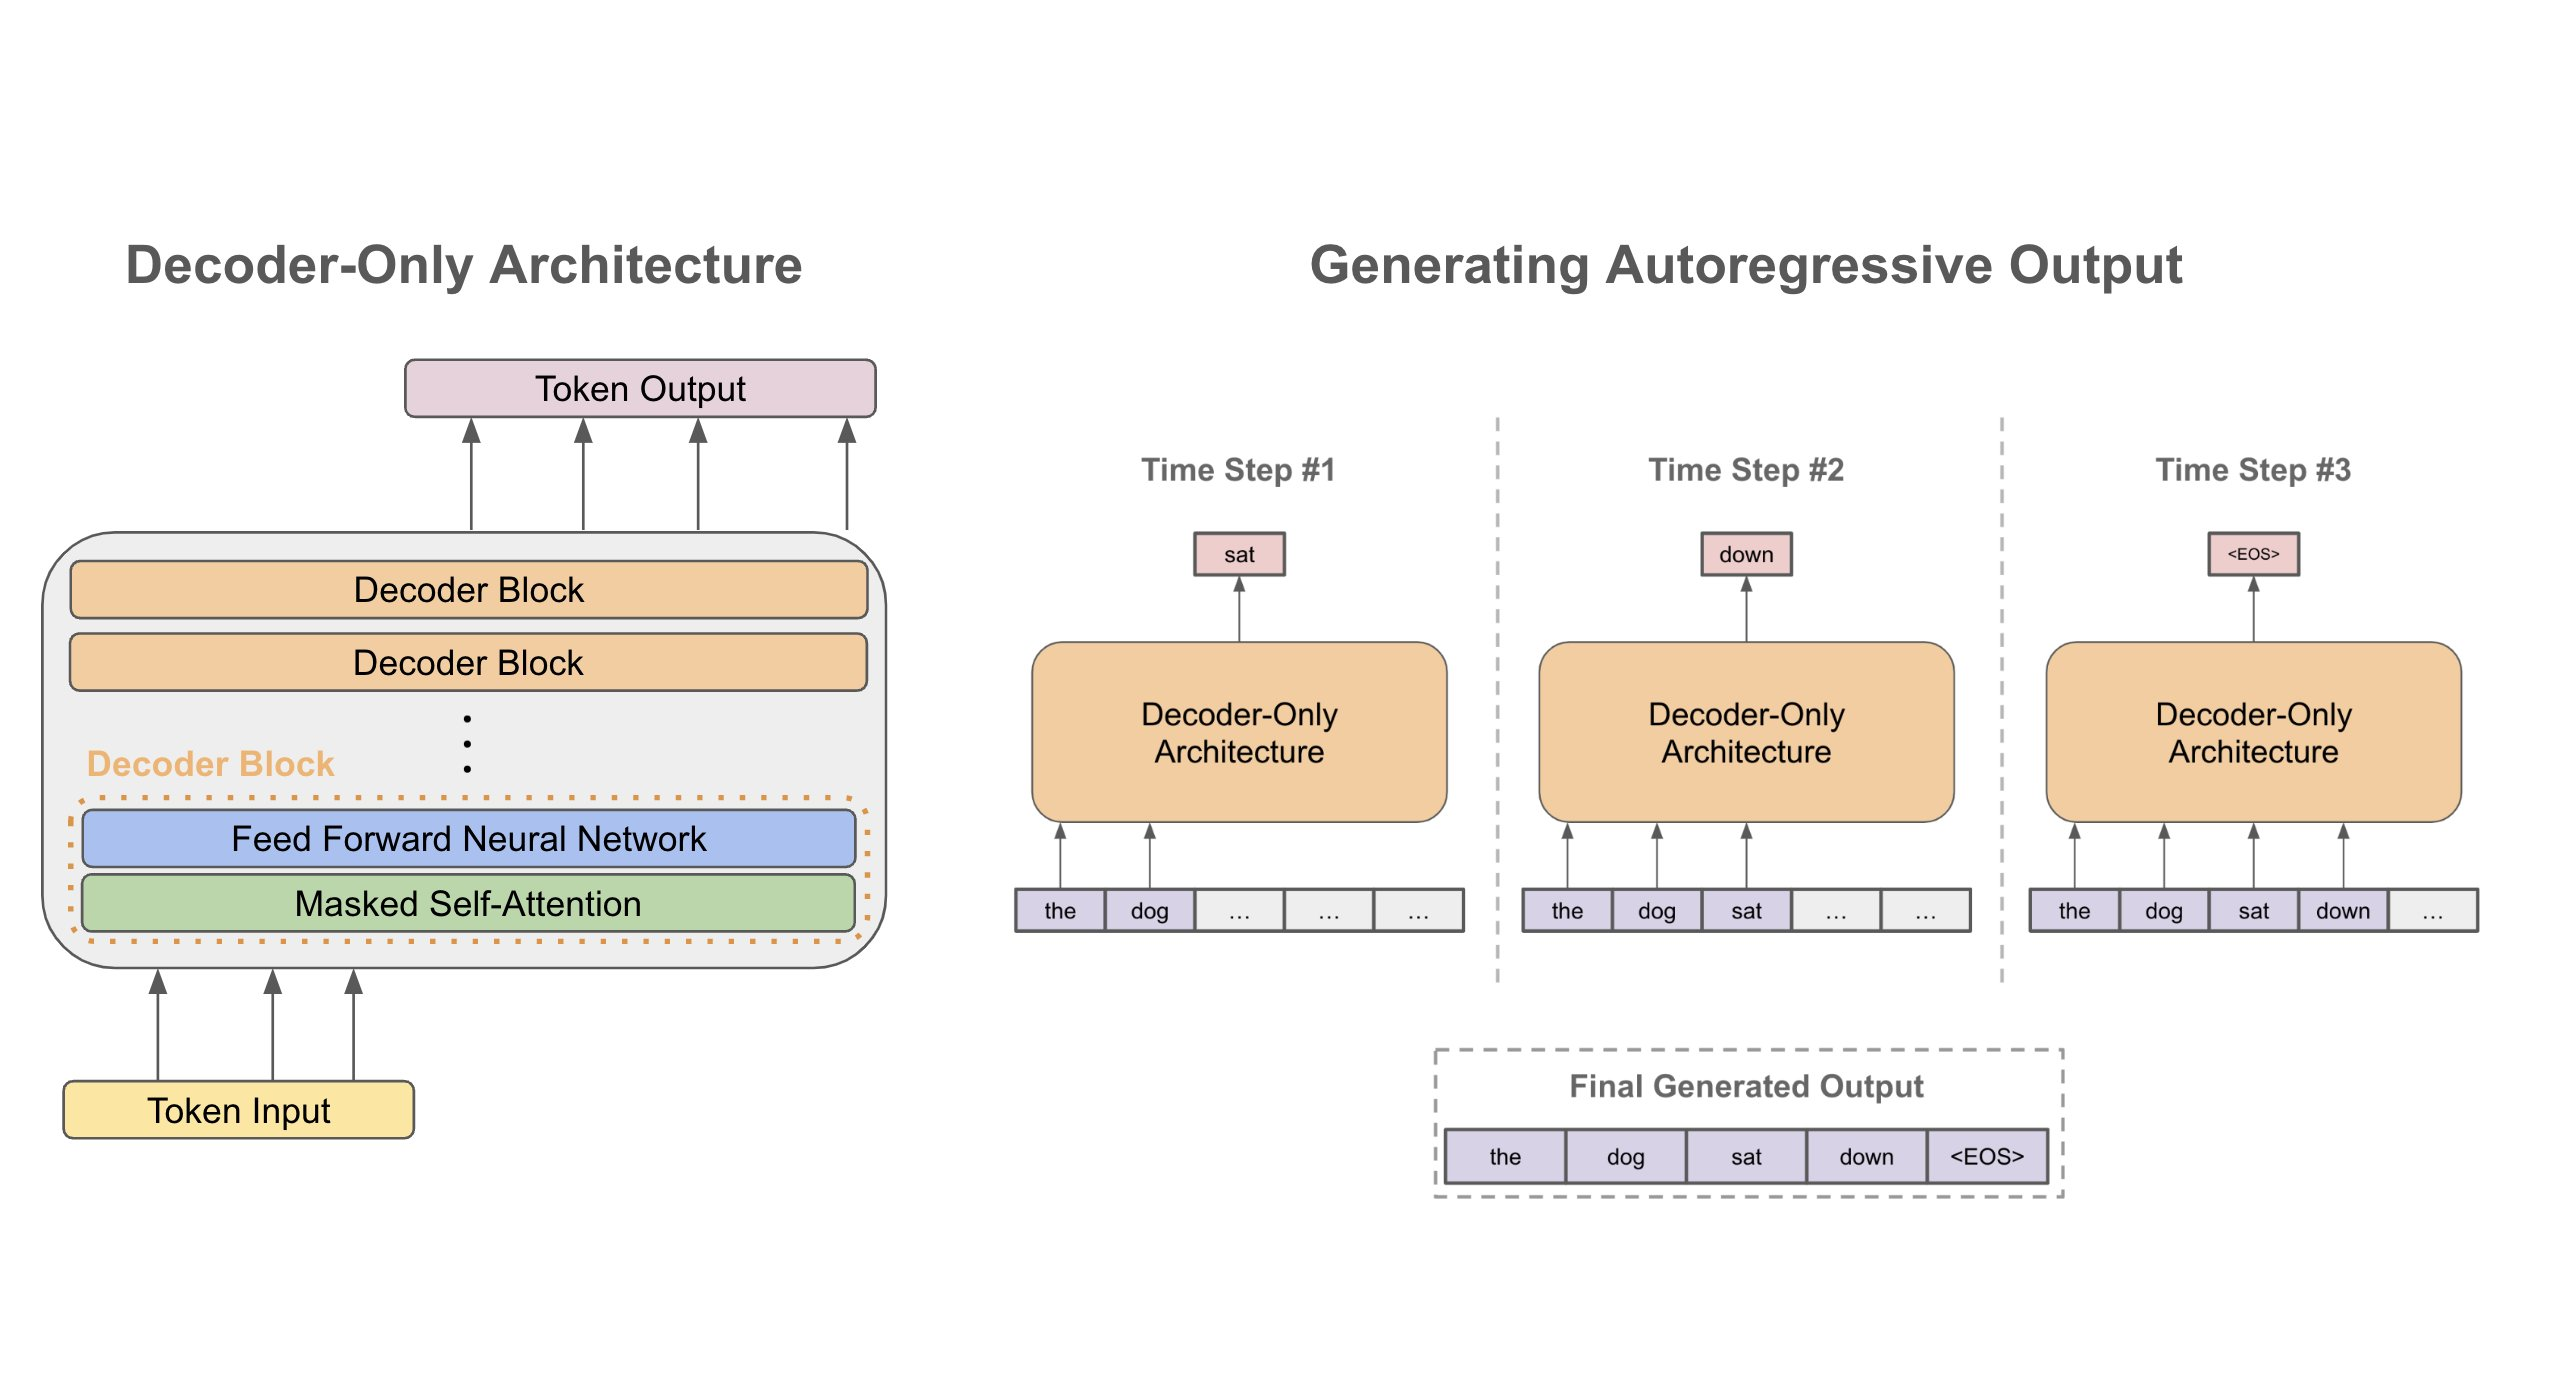

In [ ]:
class Decoder(nn.Module):
  def __init__(self, vocab_size, max_len, d_k, d_model, n_heads, n_layers, dropout_prob):
    super().__init__()

    self.embedding=nn.Embedding(vocab_size, d_model)

    self.pos_encoding=PositionalEncoding(d_model, max_len, dropout_prob)

    transformer_blocks=[TransformerBlock(d_k, d_model, n_heads, max_len, dropout_prob) for _ in range(n_layers) ]

    self.transformer_blocks = nn.Sequential(*transformer_blocks)

    self.ln = nn.LayerNorm(d_model)
    self.fc = nn.Linear(d_model, vocab_size)

  def forward(self, x, pad_mask=None):
    x=self.embedding(x)
    x=self.pos_encoding(x)
    for block in self.transformer_blocks:
      x = block(x, pad_mask)
    x = self.ln(x)
    x = self.fc(x)  # many-to-many
    return x

## **Testing model forward pass with dummy data**

In [ ]:
model = Decoder(vocab_size = 20_000, max_len=1024, d_k=16, d_model = 64, n_heads = 4,n_layers=2, dropout_prob =0.1)
device =torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Creating device for GPU and moving model to GPU
print(device)
model.to(device)

In [ ]:
x = np.random.randint(0,20_000,size=(8,512)) # Batch size of eaight & sequence length of 512, vocab size is 20k
# Token id may be anywhere between 0 to 20_000 exclusive
x_t = torch.tensor(x).to(device)

In [ ]:
y = model(x_t) # without padding
y.shape

In [ ]:
mask = np.ones((8,512)) # with padding mask
mask[:, 256:] = 0
mask_t = torch.tensor(mask).to(device)

In [ ]:
y=model(x_t,mask_t) #with mask
y.shape

# **2.Training the Decoder as causal Language Model**

## **Load the data**

In [ ]:
raw_datasets = load_dataset("glue", "sst2") # sst2 is DataSet for sentiment analysis but ignore the label

## **Define the Tokenizer**

In [ ]:
checkpoint = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation = True)

## **Tokenize the data**

In [ ]:
tokenized_datasets = raw_datasets.map(tokenize_fn, batched = True)
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

In [ ]:
tokenized_datasets

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(["sentence", "idx", "label"])

In [ ]:
train_loader =  DataLoader(tokenized_datasets["train"], shuffle = True, batch_size =32, collate_fn = data_collator)

In [ ]:
# Check how it works
for batch in train_loader:
  for k,v in batch.items():
    print("k:", k, "v.shape:", v.shape)
  break

In [ ]:
tokenizer.pad_token_id

In [ ]:
tokenizer.model_max_length

In [ ]:
tokenizer.vocab_size

## **Create the Model**

In [ ]:
model = Decoder (
    vocab_size = tokenizer.vocab_size,
    max_len=tokenizer.model_max_length,
    d_k=16,
    d_model = 64,
    n_heads = 4,
    n_layers =2,
    dropout_prob =0.1
    )
model.to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index = tokenizer.pad_token_id)
optimizer = torch.optim.Adam(model.parameters())

## **Train The Model**

In [ ]:
def train(model, criterion, optimzer, train_loader, epochs):
  train_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0=datetime.now()
    train_loss = []
    for batch in train_loader:
      # move data to GPU
      batch = {k:v.to(device) for k, v, in batch.items()}

      # zero the parameter gradients
      optimizer.zero_grad()

      # shift the targets backwards
      targets = batch['input_ids'].clone().detach()
      targets = torch.roll(targets,shifts = -1, dims = 1) #Shifting the sequence for creating target
      targets[:,-1] = tokenizer.pad_token_id

      # forward pass
      outputs = model(batch['input_ids'], batch['attention_mask'])
      loss = criterion(outputs.transpose(2,1),targets)

      # Backward and optimize
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())

    # get  train Loss and test loss
    train_loss = np.mean(train_loss)

    # save lossess
    train_losses[it] = train_loss

    dt = datetime.now() - t0
    print(f'Epoch: {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Duration: {dt}')

  return train_losses

In [ ]:
train_losses = train(model, criterion, optimizer, train_loader, epochs = 4)

## **Validation Result**

In [ ]:
valid_loader = DataLoader(tokenized_datasets["validation"], batch_size = 1, collate_fn = data_collator)

In [ ]:
model.eval()
for batch in valid_loader:
  # move data to GPU
  batch = {k:v.to(device) for k,v in batch.items()}
  outputs = model (batch['input_ids'], batch['attention_mask'])
  break

**Sample Validation Input**

In [ ]:
batch['input_ids']

In [ ]:
tokenizer.decode(batch['input_ids'][0])

**Sample Validation Prediction**

Understanding the model's prediction for each token in the input

In [ ]:
outputs.shape

In [ ]:
torch.argmax(outputs,axis=-1)

In [ ]:
prediction_ids = torch.argmax(outputs, axis=-1)

In [ ]:
prediction_ids

In [ ]:
tokenizer.decode(prediction_ids[0])

**Extracting the next word prediction from the output**

1. Output hepls us understand chance of occurance for each token
2. Extract the token id with max chance
3. Decode the extracted to token to interpret the token

In [ ]:
outputs[:,-1,:].shape

In [ ]:
outputs[:,-1,:]

In [ ]:
torch.argmax(outputs[:,-1,:], axis = -1)

In [ ]:
tokenizer.decode(torch.argmax(outputs[:,-1,:], axis = -1))

# **3. Generating Text using the model**

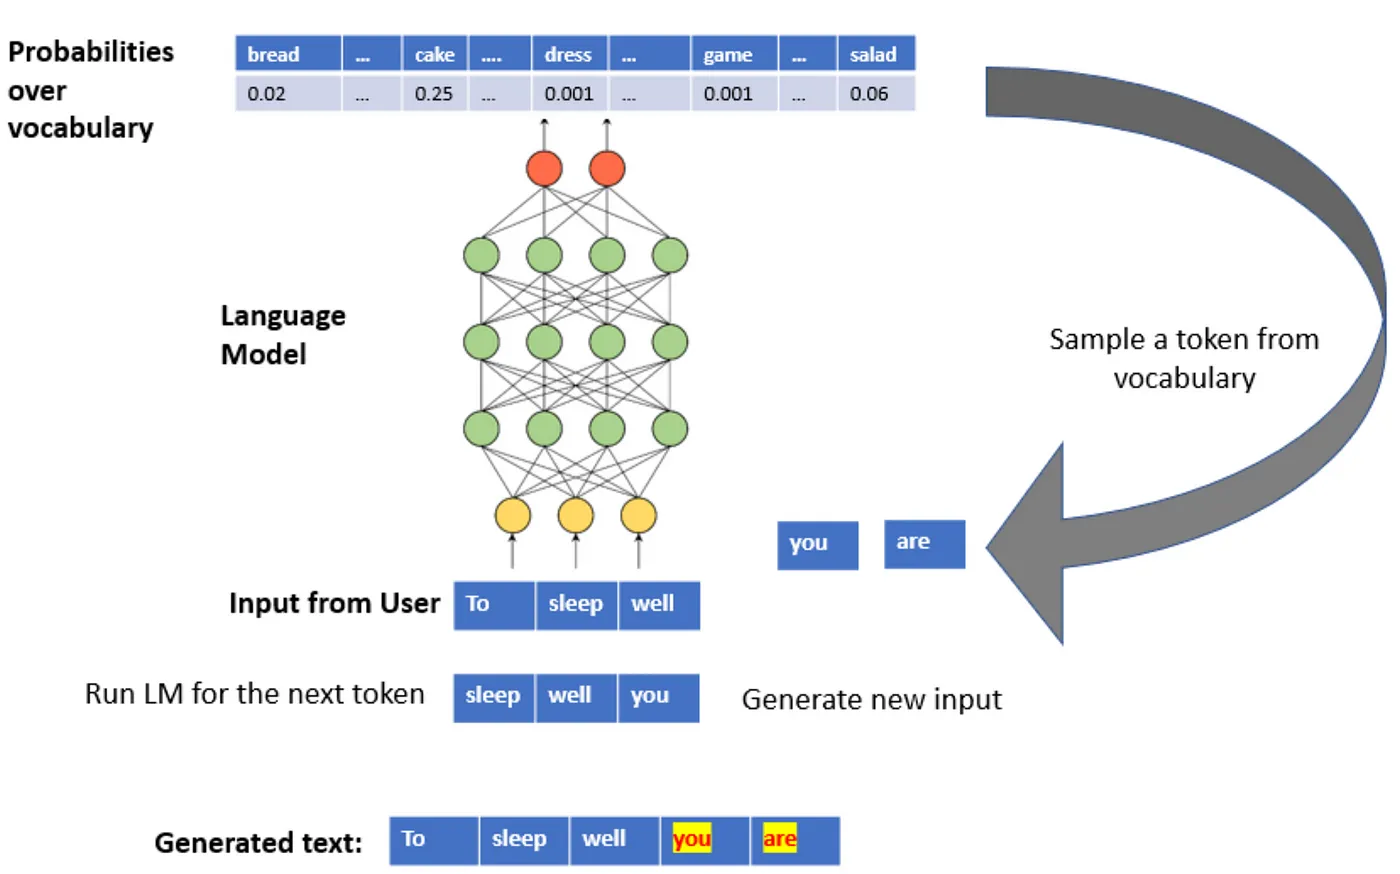

In [ ]:
prompt ="it's a"
tokenized_prompt = tokenizer(prompt, return_tensors='pt')
# prepare inputs + get rid of SEP token at the end
input_ids = tokenized_prompt['input_ids'][:,:-1].to(device)
mask = tokenized_prompt['attention_mask'][:,:-1].to(device)

for _ in range(20):
  outputs = model(input_ids, mask)
  prediction_id = torch.argmax(outputs[:,-1,:], axis = -1)

  input_ids = torch.hstack((input_ids, prediction_id.view(1,1)))
  mask = torch.ones_like(input_ids)

  if prediction_id == tokenizer.sep_token_id:
    break

In [ ]:
tokenizer.decode(input_ids[0])

# **Complete Encoder-Decoder Architecture**

Revisiting again the **Transformer Model Architecture** as per the paper ["**Attention Is All You Need**"](https://arxiv.org/pdf/1706.03762v6.pdf).
<br><br>
<center>
<img src= "https://cdn.extras.talentsprint.com/aiml/Experiment_related_data/Images/Transformer.png" width=750px/>

</center>

We have implemented both the Encoder and Decoder separately. Encoder-only architecture is BERT while Decoder-only Architecture is GPT. Similarly, the architecture that contains both Encoder and Decoder is called T5 i.e. `Text to Text Transfer Transformer`.

The figure below shows how Encoder and Decoder are connected in full Encoder and Decoder architecture.

<center>
<img src= "https://cdn.extras.talentsprint.com/aiml/Experiment_related_data/Images/encoder_decoder_connection.png" width=250px/>

</center>

## Please answer the questions below to complete the experiment:

In [ ]:
#@title What is the primary benefit of using multi-head attention in a Transformer Decoder?  { run: "auto", form-width: "500px", display-mode: "form" }
Answer = "" #@param ["", "It allows the model to process longer sequences", "It enables the model to focus on different parts of the sequence in parallel", "It reduces the number of layers in the model", "It increases the model's speed by using fewer parameters"]

In [ ]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "" #@param ["","Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging for me", "Was Tough, but I did it", "Too Difficult for me"]

In [ ]:
#@title If it was very easy, what more you would have liked to have been added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = "" #@param {type:"string"}

In [ ]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "" #@param ["","Yes", "No"]

In [ ]:
#@title  Text and image description/explanation and code comments within the experiment: { run: "auto", vertical-output: true, display-mode: "form" }
Comments = "" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]

In [ ]:
#@title Mentor Support: { run: "auto", vertical-output: true, display-mode: "form" }
Mentor_support = "" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [ ]:
#@title Run this cell to submit your notebook  { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id =return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")